# Coffee Data - Dashboard Kaffeebewertungen

In [2]:
# import modules

import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
from dash import Dash, html, dcc, callback, Output, Input
from dash.exceptions import PreventUpdate

In [3]:
# Load prepared data

df = pd.read_pickle("coffee_data.pkl")

## Daten vorbereiten

In [4]:
# Prepare data:

# Select columns with coffee ratings
cols = ["submission_id"] + [
    col for col in df.columns
    if col.startswith("coffee_") and not col.endswith("_notes")
]

# add overall ratings
prefs = ["prefer_overall", "prefer_abc", "prefer_ad"]

ratings = df[cols + prefs].copy() 
ratings.info()
del df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   submission_id                 4042 non-null   category
 1   coffee_a_bitterness           3798 non-null   category
 2   coffee_a_acidity              3779 non-null   category
 3   coffee_a_personal_preference  3789 non-null   category
 4   coffee_b_bitterness           3780 non-null   category
 5   coffee_b_acidity              3767 non-null   category
 6   coffee_b_personal_preference  3773 non-null   category
 7   coffee_c_bitterness           3764 non-null   category
 8   coffee_c_acidity              3751 non-null   category
 9   coffee_c_personal_preference  3766 non-null   category
 10  coffee_d_bitterness           3767 non-null   category
 11  coffee_d_acidity              3765 non-null   category
 12  coffee_d_personal_preference  3764 non-null   ca

In [5]:
# Fehlende Werte
cols = ratings.columns[1:]

for col in cols:
    if 'keine Angabe' not in ratings[col].cat.categories:
        ratings[col] = ratings[col].cat.add_categories("keine Angabe")
    ratings[col] = ratings[col].fillna("keine Angabe")

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   submission_id                 4042 non-null   category
 1   coffee_a_bitterness           4042 non-null   category
 2   coffee_a_acidity              4042 non-null   category
 3   coffee_a_personal_preference  4042 non-null   category
 4   coffee_b_bitterness           4042 non-null   category
 5   coffee_b_acidity              4042 non-null   category
 6   coffee_b_personal_preference  4042 non-null   category
 7   coffee_c_bitterness           4042 non-null   category
 8   coffee_c_acidity              4042 non-null   category
 9   coffee_c_personal_preference  4042 non-null   category
 10  coffee_d_bitterness           4042 non-null   category
 11  coffee_d_acidity              4042 non-null   category
 12  coffee_d_personal_preference  4042 non-null   ca

In [6]:
# Einzelbewertungen in long format
ratings_long = ratings.melt(
    id_vars="submission_id",
    var_name="variable",
    value_name="value"
)

# Adjust variable names
ratings_long[['prefix', 'coffee', 'attribute']] = ratings_long['variable'].str.extract(r'(coffee)_([a-zA-Z]+)_(\w+)')
ratings_long = ratings_long[ratings_long['prefix'].notna()]

# Pivot to tidy long format
ratings_long = ratings_long.pivot_table(
    index=['submission_id', 'coffee'],
    columns='attribute',
    values='value',
    aggfunc='first',
    observed=False
).reset_index()

ratings_long.columns.name = None  # Spaltenname bei Index entfernen
ratings_long

,submission_id,coffee,acidity,bitterness,personal_preference
0,0E11K6,a,3.0,3.0,4.0
1,0E11K6,b,2.0,3.0,4.0
2,0E11K6,c,2.0,3.0,3.0
3,0E11K6,d,4.0,4.0,1.0
4,0E1D5Z,a,4.0,2.0,4.0
...,...,...,...,...,...
16163,zKWy91,d,5.0,1.0,4.0
16164,zKdykZ,a,2.0,3.0,1.0
16165,zKdykZ,b,2.0,4.0,3.0
16166,zKdykZ,c,3.0,4.0,5.0


## Hauptabbildung Dashboard


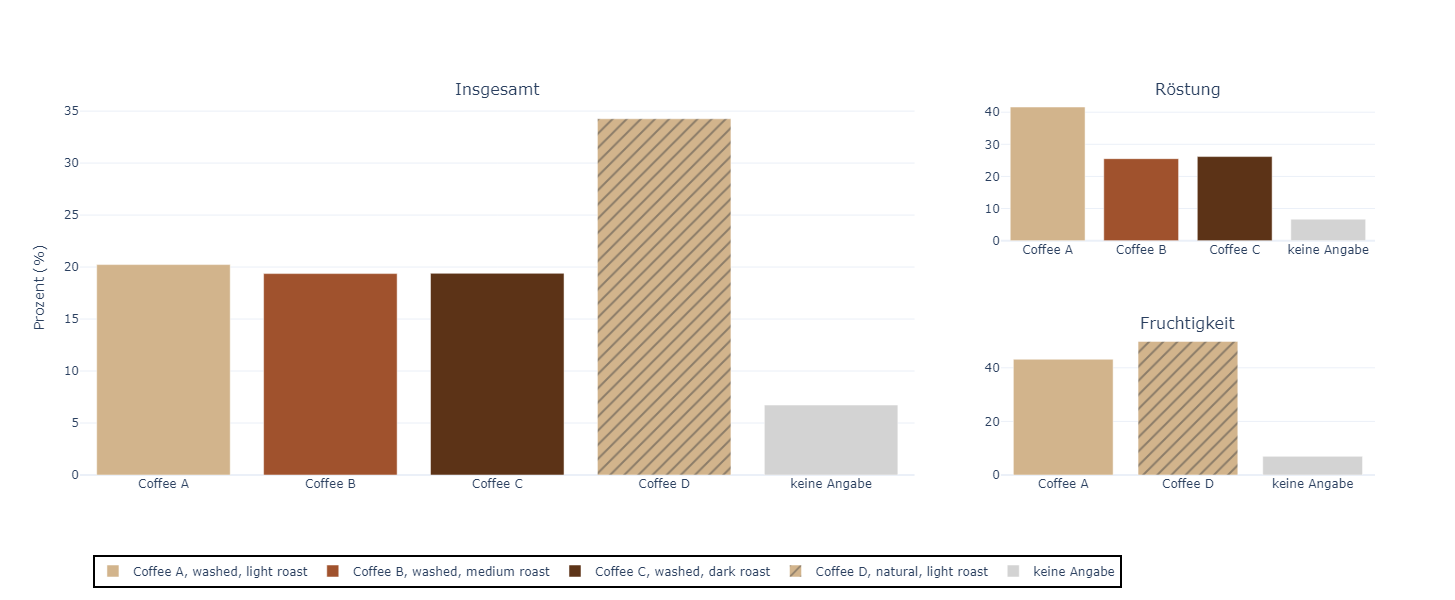

In [7]:
# Abbildung bevorzugte Sorte (3 Hauptfragen)

prefs = ["prefer_overall", "prefer_abc", "prefer_ad"]

c_map = {
    "Coffee A": "#d2b48c",
    "Coffee D": "#d2b48c",
    "Coffee B": "#a0522d",
    "Coffee C": "#5c3317",
    "keine Angabe": "#d3d3d3"
}

p_map = {
    "Coffee A": "",
    "Coffee D": "/",
    "Coffee B": "",
    "Coffee C": "",
    "keine Angabe": ""
}

fig_main = make_subplots(
    rows=2, cols=3,
    specs=[[{"rowspan": 2, "colspan": 2}, None, {"type": "xy"}],
           [None, None, {"type": "xy"}]],
    shared_yaxes=True,
    subplot_titles=["Insgesamt", "Röstung", "Fruchtigkeit"]
)

for i, pref in enumerate(prefs):
    
    df_cat = ratings.groupby(pref, observed=False).size().reset_index(name="counts")
    # Prozent berechnen
    total = df_cat['counts'].sum()
    df_cat['percent'] = df_cat['counts'] / total * 100
    df_cat['coffee'] = df_cat[pref]
    
    p = px.bar(
        df_cat,
        x=pref,
        y="percent",
        color="coffee",
        pattern_shape="coffee",
        custom_data=["coffee"],
        color_discrete_map=c_map,
        pattern_shape_map=p_map,
        template="plotly_white"
    )
    
    if i == 0:
        target_row, target_col = 1, 1
    elif i == 1:
        target_row, target_col = 1, 3
    else:
        target_row, target_col = 2, 3
    
    for trace in p.data:
        trace.showlegend = (i == 0)
        fig_main.add_trace(trace, row=target_row, col=target_col)

fig_main.update_yaxes(title_text="Prozent (%)", row=1, col=1)
fig_main.update_layout(height=600, width=800, template="plotly_white",
                      legend=dict(
                          orientation="h",
                          yanchor="bottom",
                          y=-0.3,
                          xanchor="left",
                          x=0.01,
                          bordercolor="Black",
                          borderwidth=2
                        ))
fig_main.update_traces({'name': 'Coffee A, washed, light roast'}, selector={'name': 'Coffee A'})
fig_main.update_traces({'name': 'Coffee B, washed, medium roast'}, selector={'name': 'Coffee B'})
fig_main.update_traces({'name': 'Coffee C, washed, dark roast'}, selector={'name': 'Coffee C'})
fig_main.update_traces({'name': 'Coffee D, natural, light roast'}, selector={'name': 'Coffee D'})

## Interaktives Dashboard mit Einzelbewertungen

In [24]:
coffees = [x.upper() for x in ratings_long["coffee"].unique()]
cols = ["personal_preference", "acidity", "bitterness"]

# Initialize the app without style sheet
app=Dash()

# App layout
app.layout = html.Div([
    html.Div(className='row', children='Kaffeebewertungen',
            style={'textAlign': 'center', 'color': 'black', 'fontSize': 30}),
    html.Hr(),
    html.Div([
        html.Div([
            html.Div(className='row', children='bevorzugte Sorte',
                style={'textAlign': 'left', 'color': 'black', 'fontSize': 20}),
            dcc.Graph(id='basic-interactions', figure=fig_main)
    ], style={'width': '55%', 'display': 'inline-block', 'verticalAlign': 'top'}),
            
        html.Div([
            html.Div(className='row', children='detaillierte Bewertung',
                style={'textAlign': 'left', 'color': 'black', 'fontSize': 20}),
            dcc.Graph(id='details-plot', style={'marginLeft': '20px'}),
            html.Div([
                html.Img(id='coffee-image', style={
                'width': 'auto',            
                'height': '300px', 
                'objectFit': 'contain',
                'display': 'block',
                'margin': '10px auto',      
                'border': '3px solid orange',
                'borderRadius': '8px',
                'padding': '4px'
            })], id='coffee-images')
        ], style={'width': '40%', 'display': 'inline-block', 'verticalAlign': 'top'})
    ])
])
             

# Add controls to build the interaction
@callback(
    Output(component_id='details-plot', component_property='figure'),
    Output('coffee-image', 'src'),
    Input(component_id='basic-interactions', component_property='hoverData')
)
def update_graph(hoverData):
          
    if not hoverData:
        cof_chosen = "A"          
    else:
        cof_chosen = hoverData['points'][0]['customdata'][0][-1]

    if cof_chosen == "e":
        raise PreventUpdate
  
    df_cof = ratings_long[ratings_long["coffee"]==cof_chosen.lower()]
    
    # Create a subplot layout
    fig = make_subplots(rows=1, cols=len(cols), shared_yaxes=True, subplot_titles=["Gesamtbewertung", "Säure", "Bitterkeit"])
    
    for i, col in enumerate(cols):
        df_cat = df_cof.groupby(by=col, observed=False).size().reset_index(name="counts")
        # Prozent berechnen
        total = df_cat['counts'].sum()
        df_cat['percent'] = df_cat['counts'] / total * 100
        p = px.bar(df_cat, x=col, y="percent", color_discrete_sequence=[c_map.get(f"Coffee {cof_chosen}", "#999999")],)
        pattern = p_map.get(f"Coffee {cof_chosen}", "")  # hier deine p_map
        print(pattern)
        # Add traces from Plotly Express figures to the subplot
        for trace in p.data:
            trace.marker.pattern = dict(shape=pattern, solidity=0.2)
            fig.add_trace(trace, row=1, col=i+1)
    
    # Update layout
    fig.update_yaxes(title_text="Prozent (%)", row=1, col=1)
    fig.update_layout(title_text=f"Details Kaffee {cof_chosen.upper()} ", showlegend=False, template="plotly_white", height=400)

    # Wortwolke anzeigen
    img_src = f'/assets/Coffee {cof_chosen}_wordcloud.png'
    
    return fig, img_src

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8061)

## Bewertungsdaten speichern

In [ ]:
ratings.to_pickle('coffee_data_ratings.pkl')